In [1]:
import pandas as pd
import numpy as np
import sys
import os


In [2]:
import pandas as pd

df = pd.read_csv('/workspaces/Early-Dementia-Detection/preprocessed_data.csv')
print(df.columns.tolist())


['Text', 'Label', 'Processed_Text']


In [3]:
X_text = df['Processed_Text']  
y_text = df['Label']  


In [4]:
import os

# Check current working directory
print("Current Working Directory:", os.getcwd())

# If not in project root, set it
if not os.getcwd().endswith("Early-Dementia-Detection"):
    os.chdir("/workspaces/Early-Dementia-Detection")
    print("Changed to project root:", os.getcwd())


Current Working Directory: /workspaces/Early-Dementia-Detection/notebooks
Changed to project root: /workspaces/Early-Dementia-Detection


In [7]:
import sys
sys.path.append("/workspaces/Early-Dementia-Detection/scripts")
from preprocess_audio import load_audio_dataset

# In your main script or notebook
#from scripts.preprocess_audio import load_audio_dataset

X_audio, y_audio = load_audio_dataset("data/audio data")
print(X_audio.shape)  # (n_samples, 13, 300)
print(np.bincount(y_audio))  # Class balance check


(549, 13, 300)
[308 241]


In [8]:
from sklearn.model_selection import train_test_split
from scripts.preprocess_text import load_text_data

df_text = load_text_data("preprocessed_data.csv")
print(df_text.columns)

X_text = df_text[['cleaned_text']]
y_text = df_text['Label']


# Split
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text, y_text, test_size=0.2, stratify=y_text, random_state=42)


# Train-test split for audio (already extracted earlier)
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio, test_size=0.2, stratify=y_audio, random_state=42)


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Index(['Text', 'Label', 'Processed_Text', 'cleaned_text'], dtype='object')


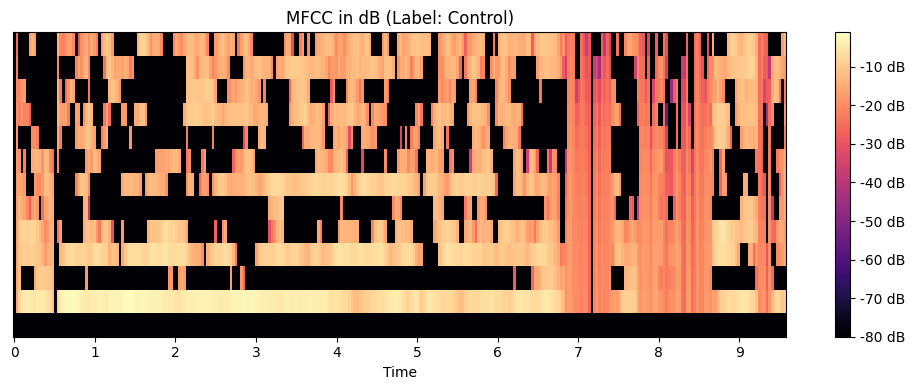

In [9]:
import matplotlib.pyplot as plt
import librosa.display
import random

# Pick a random sample
idx = random.randint(0, len(X_audio)-1)
mfcc_sample = X_audio[idx]
label = y_audio[idx]

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_sample, x_axis='time', sr=16000)  # assuming sr=16k
plt.colorbar(format="%+2.0f dB")
plt.title(f'MFCC in dB (Label: {"Control" if label==1 else "Dementia"})')
plt.tight_layout()
plt.show()




In [10]:
# For audio
import numpy as np
print("Audio labels:", np.bincount(y_audio))  # [dementia, control]

# For text
print("Text labels:", y_text.value_counts())  # Should be balanced ideally


Audio labels: [308 241]
Text labels: Label
1    1039
0     247
Name: count, dtype: int64


<Axes: title={'center': 'transcript_length'}, xlabel='[Label]'>

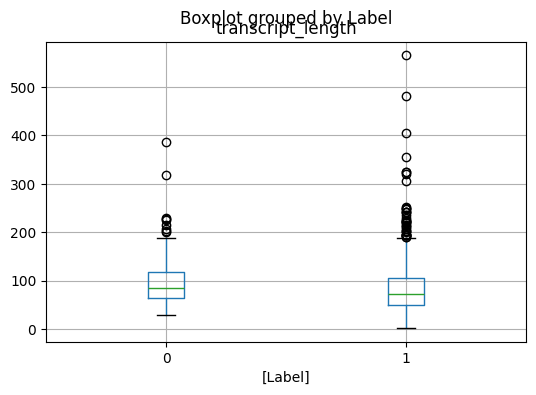

In [11]:
df_text['transcript_length'] = df_text['Text'].apply(lambda x: len(str(x).split()))

df_text[['Label', 'transcript_length']].boxplot(by='Label', figsize=(6,4))


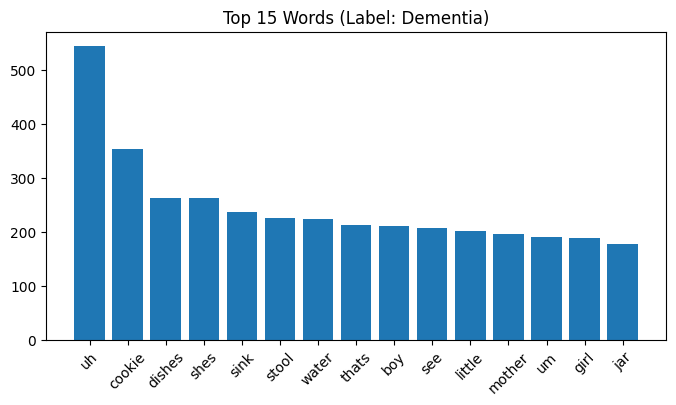

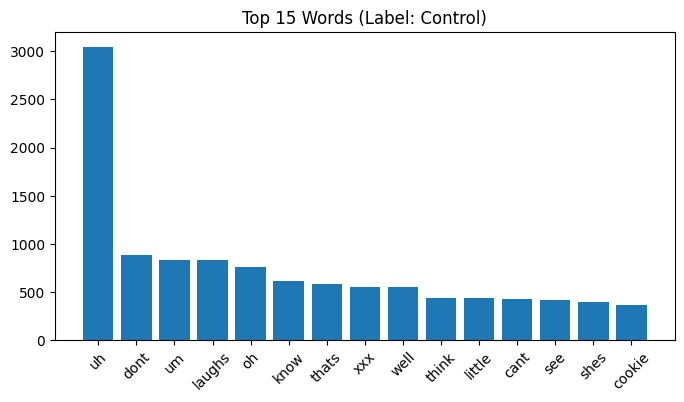

In [12]:
#Word frequency Analysis:
from collections import Counter
import matplotlib.pyplot as plt

def plot_top_words(df, label_value, top_n=15):
    texts = df[df['Label'] == label_value]['cleaned_text']
    all_words = " ".join(texts).split()
    freq_dist = Counter(all_words).most_common(top_n)

    words, counts = zip(*freq_dist)
    plt.figure(figsize=(8, 4))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} Words (Label: {'Control' if label_value==1 else 'Dementia'})")
    plt.show()

plot_top_words(df_text, 0)  # Dementia
plot_top_words(df_text, 1)  # Control


In [13]:
#POS tag counts
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')  # For newer NLTK versions

def get_pos_counts(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    pos_counts = Counter(tag for word, tag in tags)
    return pos_counts

# Apply per transcript
df_text['pos_counts'] = df_text['cleaned_text'].apply(get_pos_counts)

# Aggregate per class
pos_by_class = {label: Counter() for label in df_text['Label'].unique()}
for _, row in df_text.iterrows():
    pos_by_class[row['Label']].update(row['pos_counts'])

print("\nPOS counts per class:")
for label, counts in pos_by_class.items():
    print(f"Label {label} ({'Control' if label==1 else 'Dementia'}):", counts.most_common(10))


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/codespace/nltk_data...


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.



POS counts per class:
Label 1 (Control): [('NN', 16712), ('JJ', 9882), ('NNS', 5398), ('VBP', 3611), ('RB', 2494), ('VBG', 2422), ('VBD', 1841), ('VB', 1447), ('VBZ', 1087), ('IN', 796)]
Label 0 (Dementia): [('NN', 3546), ('NNS', 2080), ('JJ', 2051), ('VBG', 1848), ('VBP', 839), ('RB', 502), ('IN', 308), ('VBZ', 249), ('VBD', 211), ('VB', 207)]


In [14]:
#Hesitation words detection:
hesitations = {"um", "uh", "er", "ah", "mm"}

def count_hesitations(text):
    words = text.lower().split()
    return sum(1 for w in words if w in hesitations)

df_text['hesitation_count'] = df_text['cleaned_text'].apply(count_hesitations)

# Compare per class
df_text.groupby('Label')['hesitation_count'].describe()


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,247.0,3.000000,2.971408,0.0,1.0,2.0,4.0,18.0
1,1039.0,3.772859,5.118857,0.0,0.0,2.0,5.0,41.0


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


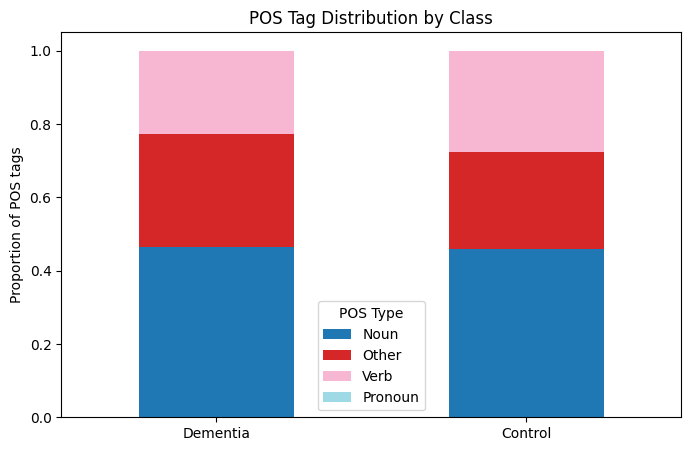

In [15]:
#Stacked POS bar chart
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter

# Make sure POS tagger is available
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Map detailed POS tags to broader categories
POS_MAP = {
    'NN': 'Noun', 'NNS': 'Noun', 'NNP': 'Noun', 'NNPS': 'Noun',
    'VB': 'Verb', 'VBD': 'Verb', 'VBG': 'Verb', 'VBN': 'Verb', 'VBP': 'Verb', 'VBZ': 'Verb',
    'PRP': 'Pronoun', 'PRP$': 'Pronoun', 'WP': 'Pronoun', 'WP$': 'Pronoun'
}

def get_broad_pos_counts(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    counts = Counter()
    for word, tag in tags:
        broad_tag = POS_MAP.get(tag, 'Other')
        counts[broad_tag] += 1
    return counts

# Apply POS counts per transcript
df_text['pos_counts'] = df_text['cleaned_text'].apply(get_broad_pos_counts)

# Aggregate and normalize per class
pos_summary = {}
for label in df_text['Label'].unique():
    total_counts = Counter()
    for counts in df_text[df_text['Label'] == label]['pos_counts']:
        total_counts.update(counts)
    total = sum(total_counts.values())
    pos_summary[label] = {pos: count/total for pos, count in total_counts.items()}

# Create DataFrame for plotting
pos_df = pd.DataFrame(pos_summary).fillna(0).T  # rows=labels, cols=POS types

# Plot stacked bar chart
pos_df.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='tab20')
plt.xticks([0, 1], ['Dementia', 'Control'], rotation=0)
plt.ylabel("Proportion of POS tags")
plt.title("POS Tag Distribution by Class")
plt.legend(title="POS Type")
plt.show()


<Figure size 600x400 with 0 Axes>

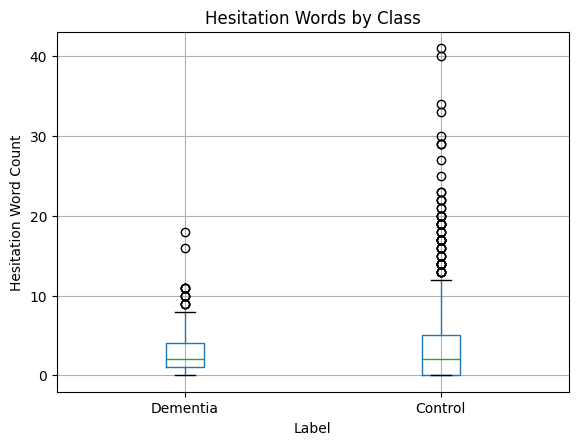

In [ ]:
#Hesitation Words Boxplot
# Hesitation words set
hesitations = {"um", "uh", "er", "ah", "mm"}

def count_hesitations(text):
    words = text.lower().split()
    return sum(1 for w in words if w in hesitations)

df_text['hesitation_count'] = df_text['cleaned_text'].apply(count_hesitations)

# Boxplot
plt.figure(figsize=(6, 4))
df_text.boxplot(column='hesitation_count', by='Label')
plt.xticks([1, 2], ['Dementia', 'Control'])
plt.ylabel("Hesitation Word Count")
plt.title("Hesitation Words by Class")
plt.suptitle("")  # Remove default title
plt.show()


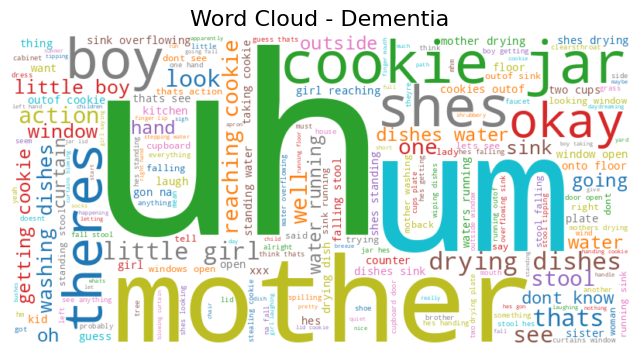

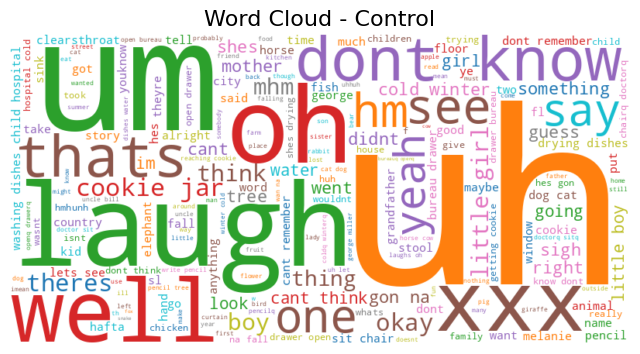

In [ ]:
#WordClouds For Each Class:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud for a specific label
def generate_wordcloud(label_value, title):
    text_data = " ".join(df_text[df_text['Label'] == label_value]['cleaned_text'])
    wc = WordCloud(width=800, height=400, background_color='white', colormap='tab10').generate(text_data)

    plt.figure(figsize=(8, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Dementia group
generate_wordcloud(0, "Word Cloud - Dementia")

# Control group
generate_wordcloud(1, "Word Cloud - Control")
